In [ ]:
import numpy as np
import torchvision
import time
import os
import copy
import collections
import torch.optim as optimy
import pdb
import time
import argparse
import torch.nn as nn
import sys
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torchvision
import cv2
import warnings
warnings.filterwarnings("ignore")
import torch
import retinanet.model as retinanet_model
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import precision_recall_fscore_support
from torchvision import datasets, models, transforms

from retinanet.dataloader import CocoDataset, CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter,UnNormalizer, Normalizer


assert torch.__version__.split('.')[0] == '1'

print('CUDA available: {}'.format(torch.cuda.is_available()))



In [ ]:
def draw_caption(image, box, caption):

    b = np.array(box).astype(int)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 0), 2)
    cv2.putText(image, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1)

In [ ]:
# # Save image with bbox, flag_save
# # csv file location  for evaluation, valid_csv
# # csv file location  for class details, class_csv
# # Final best model location, best_model
# flag_save = sys.argv[0]
# valid_csv = sys.agv[1]
# clss_csv = sys.argv[2]

In [ ]:
# Reference : https://github.com/qqadssp/RetinaNet-Pytorch/blob/master/utils/utils.py
def box_iou(box1, box2, order='xyxy'):
    '''Compute the intersection over union of two set of boxes.
    The default box order is (xmin, ymin, xmax, ymax).
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
      order: (str) box order, either 'xyxy' or 'xywh'.
    Return:
      (tensor) iou, sized [N,M].
    Reference:
      https://github.com/chainer/chainercv/blob/master/chainercv/utils/bbox/bbox_iou.py
    '''
    if order == 'xywh':
        box1 = change_box_order(box1, 'xywh2xyxy')
        box2 = change_box_order(box2, 'xywh2xyxy')

    N = box1.size(0)
#     print(box1,box2)
    M = box2.size(0)

    lt = torch.max(box1[:,None,:2], box2[:,:2])  # [N,M,2]
    rb = torch.min(box1[:,None,2:], box2[:,2:])  # [N,M,2]

    wh = (rb-lt+1).clamp(min=0)      # [N,M,2]
    inter = wh[:,:,0] * wh[:,:,1]  # [N,M]

    area1 = (box1[:,2]-box1[:,0]+1) * (box1[:,3]-box1[:,1]+1)  # [N,]
    area2 = (box2[:,2]-box2[:,0]+1) * (box2[:,3]-box2[:,1]+1)  # [M,]
    iou = inter / (area1[:,None] + area2 - inter)
    return iou

In [ ]:
dataset_val = CSVDataset(train_file="myvaliddataset.csv", class_list="class_detail.csv", transform=transforms.Compose([Normalizer(), Resizer()]))
sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1, drop_last=False)
dataloader_val = DataLoader(dataset_val, num_workers=1, collate_fn=collater, batch_sampler=sampler_val)
retinanet = torch.load("./Best_model/model_final.pt")
use_gpu = True
if use_gpu:
    retinanet = retinanet.cuda()
retinanet.eval()
unnormalize = UnNormalizer()

In [ ]:
iou_total = []
coor_pred = []
coor_true = []
true_label = []
pred_label = []
for idx, data in enumerate(dataloader_val):
    with torch.no_grad():
        st = time.time()
        scores, classification, transformed_anchors = retinanet(data['img'].cuda().float())
#         print('Elapsed time: {}'.format(time.time()-st))
        idxs = np.where(scores.cpu()>0.5)
        img = np.array(255 * unnormalize(data['img'][0, :, :, :])).copy()

        img[img<0] = 0
        img[img>255] = 255

        img = np.transpose(img, (1, 2, 0))

        img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_BGR2RGB)
        temp = []
        temp1 = []
        for j in range(idxs[0].shape[0]):
            bbox = transformed_anchors[idxs[0][j], :]
            x1 = int(bbox[0])
            y1 = int(bbox[1])
            x2 = int(bbox[2])
            y2 = int(bbox[3])
            temp.append([x1,y1,x2,y2])
            label_name = dataset_val.labels[int(classification[idxs[0][j]])]
            temp1.append(label_name)
            draw_caption(img, (x1, y1, x2, y2), label_name)
            cv2.rectangle(img, (x1, y1), (x2, y2), color=(0, 0, 255), thickness=2)
        true_annot = data["annot"]
        coor_pred.append(temp)
        pred_label.append(temp1)
        iou = 0
        
        for i in range(len(true_annot)):
            temp = []
            temp1 = []
            for k in range(len(true_annot[0])):
                    
                a1 = int(true_annot[i][k][0])
                a2 = int(true_annot[i][k][1])
                a3 = int(true_annot[i][k][2])
                a4 = int(true_annot[i][k][3])
                
                lab = dataset_val.labels[int(true_annot[0][0][4])]
                temp.append([a1,a2,a3,a4])
                temp1.append(lab)
                draw_caption(img, (a1, a2, a3, a4), lab)
        
                cv2.rectangle(img, (a1, a2), (a3, a4), color=(0, 255,0), thickness=2)
                
            coor_true.append(temp)
            true_label.append(temp1)
        
        
#             print(label_name)
#         print(idx)
#         cv2.imwrite("./images/"+"img_"+label_name+str(idx)+".jpg",img)

In [ ]:
!pip install torchsummary

In [ ]:
dict_label = {}
dict_label["coyote"]=0
dict_label["bobcat"]=1
dict_label["bird"]=2
dict_label["raccoon"]=3
dict_label["car"]=4
dict_label["rabbit"]=5
dict_label["squirrel"]=6
dict_label["cat"]=7

In [ ]:
iou_total = []
conf_matrix = []
for i in range(len(dict_label.keys())+1):
    
    conf_matrix.append([0 for i in range(len(dict_label.keys())+1)])
for i in range(len(coor_pred)):
    if len(coor_pred[i]) >=2 and len(coor_true[i]) >=2:
        
        for j in range(len(coor_pred[i])):
            try:
                sum = box_iou(torch.from_numpy(np.array(coor_true[i][j],dtype="float64")), torch.from_numpy(np.array(coor_pred[i][j],dtype="float64")))
                if sum >=0.5:
                    if pred_label[i][j] == true_label[i][j]:
                        
                        conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][j][0]]] = conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][j][0]]] +1
                iou_total.append(sum)
                continue
            except:
                pass
    elif len(coor_true[i])>=2:
         for j in range(len(coor_true[i])):
            try:
                sum = box_iou(torch.from_numpy(np.array(coor_true[i][j],dtype="float64")), torch.from_numpy(np.array(coor_pred[i],dtype="float64")))
                iou_total.append(sum)
                if sum >=0.5:
#                     print(pred_label[i])
                    if pred_label[i] == true_label[i][j]:
                        
                        conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][j][0]]] = conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][j][0]]] +1
                continue
            except:
                
                pass
    elif len(coor_pred[i])>=2:
        for j in range(len(coor_pred[i])):
            try:
                sum = box_iou(torch.from_numpy(np.array(coor_true[i],dtype="float64")), torch.from_numpy(np.array(coor_pred[i][j],dtype="float64")))
                iou_total.append(sum)
                if sum >=0.5:
#                     print(pred_label[i])
                    if pred_label[i][j]== true_label[i]:
                        
                        conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][0]]] = conf_matrix[dict_label[pred_label[i][j][0]]][dict_label[true_label[i][0]]] +1
                continue
            except:
                pass
    elif len(coor_pred[i])==1 and len(coor_true[i])==1:
        sum = box_iou(torch.from_numpy(np.array(coor_true[i],dtype="float64")), torch.from_numpy(np.array(coor_pred[i],dtype="float64")))
        iou_total.append(sum)
        if sum >=0.5:
             
            if pred_label[i]== true_label[i]:
#                 print(pred_label[i])
                conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][0]]] = conf_matrix[dict_label[pred_label[i][0]]][dict_label[true_label[i][0]]] +1
            continue
                                                                                                          
    elif len(coor_pred)==0 and len(coor_true)==0:
        conf_matrix[8][8] = conf_matrix[8][8] + 1
        continue
    elif len(coor_pred)==0:
        if len(true_label)==0 or len(pred_label)==0:
            conf_matrix[8][8] = conf_matrix[8][8] + 1
        else:
            try:
                conf_matrix[8][dict_label[true_label[i]]] = conf_matrix[8][dict_label[true_label[i]]] +1
            except:
                conf_matrix[8][8] = conf_matrix[8][8] + 1
        continue
    else:
        if len(true_label)==0 or len(pred_label)==0:
            conf_matrix[8][8] = conf_matrix[8][8] + 1
        else:
            try:
                conf_matrix[dict_label[pred_label[i]]][8] = conf_matrix[dict_label[pred_label[i]]][8] +1
            except:
                conf_matrix[8][8] = conf_matrix[8][8] + 1
        continue
        
        pass
        

In [ ]:
# Predicted : row and True : column
conf_matrix

In [ ]:
import seaborn as sns
sns.heatmap(conf_matrix,annot=True)

In [6]:
conf_matrix = [[4,0,0,0,0,0,0,0],[0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],
               [0,0,0,1,0,0,0,0],[0,0,0,0,2,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,1],[40,43,82,64,55,58,62,68]]

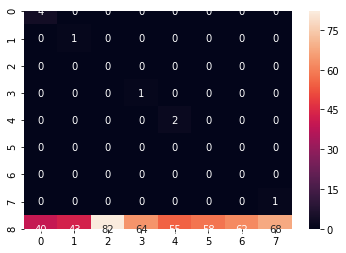

In [7]:
import seaborn as sns
sns.heatmap(conf_matrix,annot=True)

In [ ]:
iou_total_sum = 0
for i in range(len(iou_total)):
    iou_total_sum =iou_total_sum + (iou_total[i][0]).sum()/len(iou_total[i][0])
iou_final = iou_total_sum/len(iou_total)

In [ ]:
print("Final IOU for validation set : ",iou_final)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
loss = np.load("./Best_model/epoch_loss.npy")
epoch = [i for i in range(len(loss))]
plt.plot(epoch, loss,label = "Loss Curve ")
plt.title("Loss Vs Epoch Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss ")
plt.legend()
plt.show()

In [ ]:
retinanet